## **<font color='DarkBlue'>Libraries</font>**

In [1]:
# pip install dataprep

In [2]:
# pip install lightfm

In [3]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import os
import time
from scipy.sparse import csr_matrix
from dataprep.clean import clean_country
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from implicit.nearest_neighbours import bm25_weight
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, mean_average_precision_at_k, ndcg_at_k, AUC_at_k, precision_at_k
from lightfm import LightFM, cross_validation
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from lightfm.cross_validation import random_train_test_split

from nltk.corpus import stopwords
stop = stopwords.words('english')

# https://github.com/benfred/implicit
# it's super fast...
from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender
)

import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)

## **<font color='DarkBlue'>Dataset</font>**

In [4]:
# Read dataset
# https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

books = pd.read_csv('Data/archive/Books.csv', dtype='unicode')
ratings = pd.read_csv("Data/archive/Ratings.csv")
users = pd.read_csv("Data/archive/Users.csv")

**<font color='DarkBlue'>Books:</font>**
__________

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

In [5]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


**<font color='DarkBlue'>Ratings:</font>**
____________
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


**<font color='DarkBlue'>Users:</font>**
__________

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.

In [7]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


## **<font color='DarkBlue'>Data Cleaning</font>**

**<font color='DarkBlue'>Books:</font>**
__________

In [8]:
# summary of a DataFrame
# 271360 entries, 8 columns
# null values: Book-Autor = 2, Publisher = 2, Image-URL-L = 3

# Rename columns
books.rename(columns={'ISBN': 'isbn', 'Book-Title': 'book_title', 'Book-Author': 'book_author',
                     'Year-Of-Publication': 'year_publication', 'Publisher': 'publisher',
                     'Image-URL-S': 'image_url_s', 'Image-URL-M': 'image_url_m', 'Image-URL-L': 'image_url_l'}
                     , inplace=True)

books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   isbn              271360 non-null  object
 1   book_title        271360 non-null  object
 2   book_author       271359 non-null  object
 3   year_publication  271360 non-null  object
 4   publisher         271358 non-null  object
 5   image_url_s       271360 non-null  object
 6   image_url_m       271360 non-null  object
 7   image_url_l       271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [9]:
# show null values

# ISBN 0751352497 - Not fond book-author
# ISBN 9627982032 - Not fond book-author

# ISBN 193169656X - Publisher: NovelBooks, Inc.
# https://www.abebooks.com/9781931696562/Tyrant-Moon-Corvidae-Elaine-193169656X/plp

# ISBN 1931696993 - Publisher: NovelBooks, Inc.
# https://www.abebooks.com/9781931696999/Finders-Keepers-Linnea-Sinclair-1931696993/plp

books[books.isna().any(axis=1)]

,isbn,book_title,book_author,year_publication,publisher,image_url_s,image_url_m,image_url_l
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [10]:
# Replace NULL with a default string
books.loc[(books.isbn == '0751352497'),'book_author'] = 'Unknown'
books.loc[(books.isbn == '9627982032'),'book_author'] = 'Unknown'
books.loc[(books.isbn == '193169656X'),'publisher'] = 'NovelBooks, Inc.'
books.loc[(books.isbn == '1931696993'),'publisher'] = 'NovelBooks, Inc.'

# ISBN '078946697X'
books.loc[books.isbn == '078946697X','year_publication'] = 2000
books.loc[books.isbn == '078946697X','book_author'] = "Michael Teitelbaum"
books.loc[books.isbn == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.isbn == '078946697X','book_title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"
books.loc[books.isbn == '078946697X','image_url_m'] = "http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg"

# ISBN 2070426769
books.loc[books.isbn == '2070426769','year_publication'] = 2003
books.loc[books.isbn == '2070426769','book_author'] = "Jean-Marie Gustave Le Clezio"
books.loc[books.isbn == '2070426769','publisher'] = "Gallimard"
books.loc[books.isbn == '2070426769','book_title'] = "Peuple du ciel, suivi de Les Bergers"
books.loc[books.isbn == '2070426769','image_url_m'] = "http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg"

# ISBN '0789466953'
books.loc[books.isbn == '0789466953','year_publication'] = 2000
books.loc[books.isbn == '0789466953','book_author'] = "James Buckley"
books.loc[books.isbn == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.isbn == '0789466953','book_title'] = """DK Readers: Creating the X-Men, How Comic Books 
                                                        Come to Life (Level 4: Proficient Readers)"""
books.loc[books.isbn == '0789466953','image_url_m'] = "http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg"

# Keep only medium image
books = books.drop(['image_url_s', 'image_url_l'], axis=1)

In [11]:
books[books.isna().any(axis=1)]

,isbn,book_title,book_author,year_publication,publisher,image_url_m


In [12]:
# Use to_numeric() to convert the 'object' dtype column to 'int' dtype
books['year_publication'] = books['year_publication'].astype(str).astype(int)

In [13]:
# Dublicate rows
books[books.duplicated()]

,isbn,book_title,book_author,year_publication,publisher,image_url_m


In [14]:
# Stat on year of publication
# min = 0, max = 2050!

books["year_publication"].describe()

count    271360.000000
mean       1959.761273
std         257.992836
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: year_publication, dtype: float64

In [15]:
# See the years of publication
print(sorted(books['year_publication'].unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


Acknowledgements:

Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

In [16]:
#However, the value 0 is invalid and as this dataset was published in 2004, we have assumed the the years after 2004 to be invalid 

#setting invalid years as NaN
books.loc[(books['year_publication'] > 2004) | (books['year_publication'] == 0),'year_publication'] = np.NAN

#replacing NaNs with mean value of yearOfPublication
books['year_publication'].fillna(round(books['year_publication'].mean(), 0), inplace=True)

#resetting the dtype
books['year_publication'] = books['year_publication'].astype(int).astype(int)

In [17]:
# See the years of publication
print(sorted(books['year_publication'].unique()))

[1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]


In [18]:
# Count unique values
books.nunique()

isbn                271360
book_title          242135
book_author         102021
year_publication       101
publisher            16804
image_url_m         271044
dtype: int64

**<font color='DarkBlue'>Ratings:</font>**
____________

In [19]:
# summary of a DataFrame
# 1149780  entries, 3 columns
# no null values

# Rename columns
ratings.rename(columns={'User-ID': 'user_id', 'ISBN': 'isbn', 'Book-Rating': 'book_rating'}
                     , inplace=True)

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   isbn         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [20]:
# Dublicate rows
ratings[ratings.duplicated()]

,user_id,isbn,book_rating


In [21]:
# ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset
ratings = ratings[ratings.isbn.isin(books.isbn)]

# it can be seen that many rows having book ISBN not part of books dataset got dropped off
# Before: 1,149,780 --> Now: 1,031,136
print(ratings.shape)

(1031136, 3)


In [22]:
#ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset
ratings = ratings[ratings['user_id'].isin(users['User-ID'])]

#no new users added, hence we will go with above dataset ratings_new (1031136, 3)
ratings.shape

(1031136, 3)

Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [23]:
# See the ratings
print(sorted(ratings['book_rating'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [24]:
# Count the rathings
rtngs = ratings.groupby(['book_rating']).agg({
    'book_rating': [('count')]})

rtngs.columns = rtngs.columns.droplevel(level=0)
rtngs

,count
book_rating,
0,647294
1,1481
2,2375
3,5118
4,7617
5,45355
6,31687
7,66402
8,91804


In [25]:
# segragating implicit and explict ratings datasets
ratings_explicit = ratings[ratings['book_rating'] != 0]
ratings_implicit = ratings[ratings['book_rating'] == 0]

**<font color='DarkBlue'>Users:</font>**
__________

In [26]:
# summary of a DataFrame
# 278858 entries, 3 columns
# Age: nul values

# Rename columns
users.rename(columns={'User-ID': 'user_id', 'Location': 'location', 'Age': 'age'}
                     , inplace=True)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [27]:
# Dublicate rows
users[users.duplicated()]

,user_id,location,age


In [28]:
# See the age
print(sorted(users['age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [29]:
# In my view values below 8 and above 180 do not make much sense for our book rating case...hence replacing these by NaNs
users.loc[(users.age > 100) | (users.age < 8), 'age'] = np.nan

#replacing NaNs with mean
users.age = users.age.fillna(users.age.mean())

#setting the data type as int
users.age = users.age.astype(np.int32)

In [30]:
# See the age
print(sorted(users['age'].unique()))

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [31]:
# Assign the countries to the dataset

countries = []
cond = users['location'].str.split(',')

for cont in cond:
    countries.append(cont[-1])

users['country'] = countries
users.head()

,user_id,location,age,country
0,1,"nyc, new york, usa",34,usa
1,2,"stockton, california, usa",18,usa
2,3,"moscow, yukon territory, russia",34,russia
3,4,"porto, v.n.gaia, portugal",17,portugal
4,5,"farnborough, hants, united kingdom",34,united kingdom


In [32]:
# Create a DataFrame with one column
country = pd.DataFrame(users, columns=['country'])

# https://docs.dataprep.ai/user_guide/clean/clean_country.html#:~:text=The%20function%20clean_country()%20cleans,is%20valid%2C%20and%20False%20otherwise.
country_clean = clean_country(country, "country", fuzzy_dist=2)

# Drop duplicate
country_clean = country_clean.drop_duplicates()
country_clean.head()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	274226 values cleaned (98.34%)
	37 values unable to be parsed (0.01%), set to NaN
Result contains 274226 (98.34%) values in the correct format and 4632 null values (1.66%)


,country,country_clean
0,usa,United States
2,russia,Russia
3,portugal,Portugal
4,united kingdom,United Kingdom
7,canada,Canada


In [33]:
users = users.join(country_clean.set_index('country'), on='country')

# drop Location & Country column and rename country_clean
users = users.drop(['location', 'country'], axis=1)
users = users.rename(columns={'country_clean': 'country'})

# Fill unknown for null values
users['country'].fillna('Unknown', inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  278858 non-null  int64 
 1   age      278858 non-null  int32 
 2   country  278858 non-null  object
dtypes: int32(1), int64(1), object(1)
memory usage: 5.3+ MB


In [34]:
# See the countries
print(sorted(users['country'].unique()))

['Afghanistan', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Chad', 'Channel Islands', 'Chile', 'China', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo Republic', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'DR Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faeroe Islands', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Gr

## **<font color='DarkBlue'>Data Exploration</font>**

**<font color='DarkBlue'>Books:</font>**
__________

In [35]:
logger.info(f'The unique number of books: {books["isbn"].nunique()}')

The unique number of books: 271360


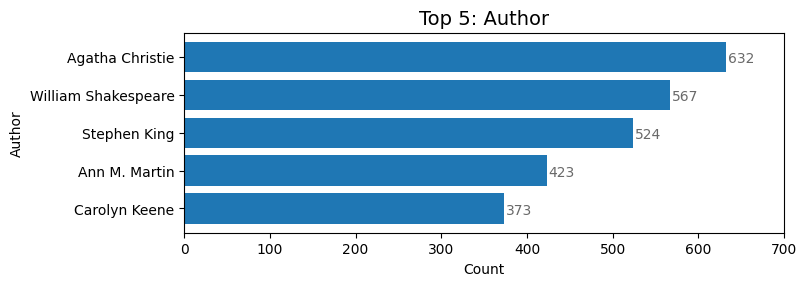

In [36]:
pop_author = books.groupby(['book_author']).agg({
    'book_author': [('count')]
})

pop_author.columns = pop_author.columns.droplevel(level=0)
pop5_author = pop_author.sort_values(by='count', ascending=False).head(5)

fig = plt.figure(figsize=(6,2))
ax = fig.add_axes([0,0,1,1])
author = pop5_author.index
cnt = pop5_author['count']
ax.barh(author, cnt)

plt.gca().invert_yaxis()

# Set the tick locations and labels
current_values = plt.gca().get_xticks()
tick_locations = [0, 100, 200, 300, 400, 500, 600, 700] 
ax.set_xticks(tick_locations)
#ax.set_xticklabels(['{:,.0f}'.format(x) for x in tick_locations])

for i, v in enumerate(cnt):
    ax.text(v + 2, i + .15, str(v), color='dimgray')

# Set the title and axis labels
plt.title('Top 5: Author', fontsize=14)
plt.ylabel('Author', fontsize=10)
plt.xlabel('Count', fontsize=10)

plt.show()

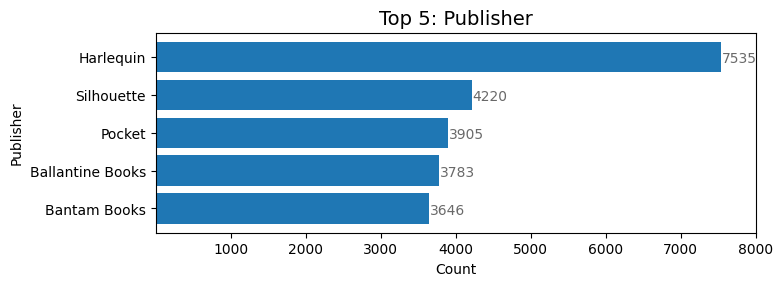

In [37]:
pop_publisher = books.groupby(['publisher']).agg({
    'publisher': [('count')]
})

pop_publisher.columns = pop_publisher.columns.droplevel(level=0)
pop5_publisher = pop_publisher.sort_values(by='count', ascending=False).head(5)

fig = plt.figure(figsize=(6,2))
ax = fig.add_axes([0,0,1,1])
publisher = pop5_publisher.index
cnt = pop5_publisher['count']
ax.barh(publisher, cnt)

plt.gca().invert_yaxis()

# Set the tick locations and labels
current_values = plt.gca().get_xticks()
tick_locations = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000] 
ax.set_xticks(tick_locations)
#ax.set_xticklabels(['{:,.0f}'.format(x) for x in tick_locations])

for i, v in enumerate(cnt):
    ax.text(v + 10, i + .15, str(v), color='dimgray')

# Set the title and axis labels
plt.title('Top 5: Publisher', fontsize=14)
plt.ylabel('Publisher', fontsize=10)
plt.xlabel('Count', fontsize=10)

plt.show()

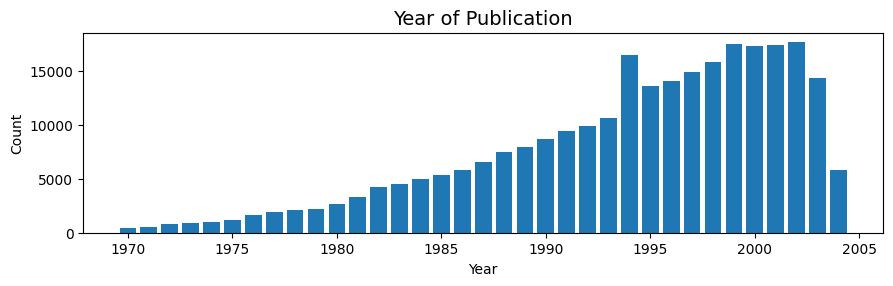

In [38]:
pop_year = books.groupby(['year_publication']).agg({
    'year_publication': [('count')]
})

pop_year.columns = pop_year.columns.droplevel(level=0)
pop_year = pop_year.sort_values(by='year_publication', ascending=False)

pop_year_1 = pop_year[pop_year.index >= 1970]

fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0,1,1])
year = pop_year_1.index
cnt = pop_year_1['count']
ax.bar(year, cnt)

# Set the title and axis labels
plt.title('Year of Publication', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Year', fontsize=10)

plt.show()

**<font color='DarkBlue'>Ratings:</font>**
____________

In [39]:
# implicit & explicit rating is 1 by user by book
# I don't have the definition for implicit rating but maybe is buy/read a book and user don't rating this one

grouped_counts = ratings.groupby(['user_id', 'isbn']).size().reset_index(name='count')
grouped_counts.sort_values(by='count', ascending=False).head(2)

,user_id,isbn,count
0,2,0195153448,1
687428,188343,0439544165,1


In [40]:
grouped_counts.shape

(1031136, 3)

In [41]:
# Create column for count the rathings
cnt_rating = ratings['book_rating'].apply(lambda x: 'No Rating' if x == 0 else 'Rating [1, 10]')

print("No Rathing = " + str(cnt_rating.value_counts()['No Rating']))
print("Rating [1, 10] = " + str(cnt_rating.value_counts()['Rating [1, 10]']))

No Rathing = 647294
Rating [1, 10] = 383842


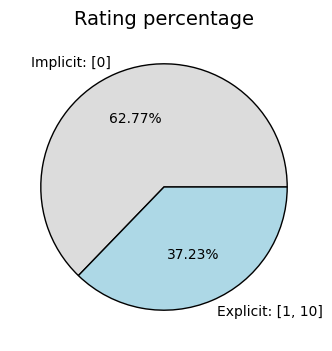

In [42]:
# Create pie chart for No Rating / Rating

plt.figure(figsize=(4,4))
plt.pie(cnt_rating.value_counts(),
        labels=['Implicit: [0]','Explicit: [1, 10]'],
        colors=['gainsboro','lightblue'],
        wedgeprops={"edgecolor":"black",'linewidth': 1, 'antialiased': True},
        autopct='%.2f%%')
plt.gca().set_aspect('equal') 
plt.title('Rating percentage', fontsize=14)
plt.show()

Explicit Ratings:

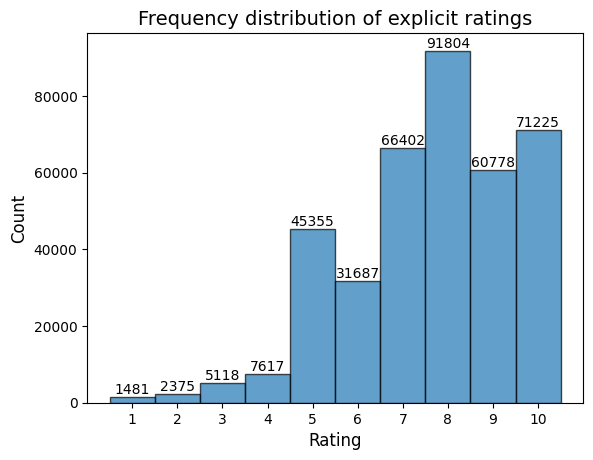

In [43]:
# Specify the number of bins and calculate bin edges
num_bins = 10  # You can adjust this as needed
hist, bin_edges = np.histogram(ratings_explicit['book_rating'], bins=num_bins)

# Calculate the bin widths
bin_width = bin_edges[1] - bin_edges[0]

# Calculate the bin midpoints
bin_midpoints = bin_edges[:-1] + bin_width / 2

# Create a histogram with the specified bins and widths
plt.hist(ratings_explicit['book_rating'], bins=bin_edges, width=bin_width, alpha=0.7, edgecolor='black')

# Add labels to the bars
for i in range(len(bin_edges) - 1):
    plt.text(
        bin_midpoints[i],  # x-coordinate for the label (bin midpoint)
        hist[i],  # y-coordinate for the label (height of the bar)
        str(round(hist[i])),  # Text to display (count in the bin)
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Set the title and axis labels
plt.title('Frequency distribution of explicit ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set x-axis tick positions to the bin midpoints
plt.xticks(bin_midpoints, [int(round(x,0)) for x in bin_midpoints])

# Display the plot
plt.show()

It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

In [44]:
# Number of ratings per user
# Some users are very prolific !!!
# Passionate readers, account with several users, bots?

pop_rting_users = ratings.groupby(['user_id']).agg({
    'user_id': [('count')]
})

pop_rting_users.columns = pop_rting_users.columns.droplevel(level=0)
pop_rting_users.sort_values(by='count', ascending=False).head()

,count
user_id,
11676,11144
198711,6456
153662,5814
98391,5779
35859,5646


In [45]:
# But we have var in the rathing of one prolific user
ratings.groupby(ratings.book_rating[ratings['user_id']==98391]).agg({
    'book_rating': [('count')]
})

,book_rating
,count
book_rating,
0.0,88
5.0,160
6.0,5
7.0,34
8.0,1496
9.0,2561
10.0,1435


In [46]:
# Calculate number rating by movie_id
avg_rating = pd.DataFrame(ratings_explicit.groupby('isbn')['book_rating'].mean())
avg_rating.rename(columns={'book_rating': 'avg_rating'}, inplace=True)
avg_rating[avg_rating.index=="038550120X"]

,avg_rating
isbn,
038550120X,7.580247


In [47]:
# 25% of the average rating for movie are equal or less of 6.5
avg_rating.describe(percentiles=[.25, .5, .75, .95, 1])

,avg_rating
count,149836.000000
mean,7.527543
std,1.711876
min,1.000000
25%,6.500000
50%,8.000000
75%,9.000000
95%,10.000000
100%,10.000000
max,10.000000


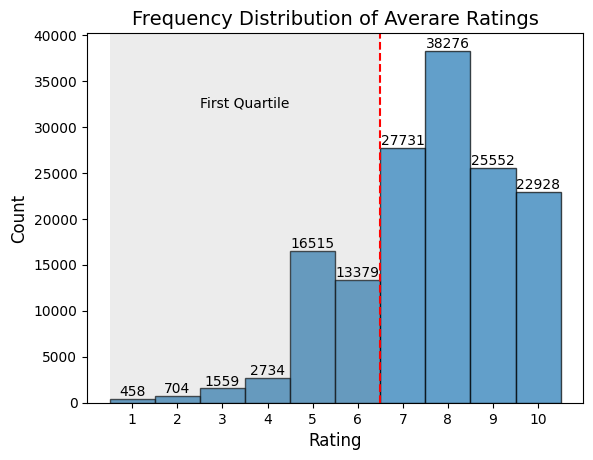

In [48]:
# Specify the number of bins and calculate bin edges
num_bins = 10  # You can adjust this as needed
hist, bin_edges = np.histogram(avg_rating['avg_rating'], bins=num_bins)

# Calculate the bin widths
bin_width = bin_edges[1] - bin_edges[0]

# Calculate the bin midpoints
bin_midpoints = bin_edges[:-1] + bin_width / 2

# Create a histogram with the specified bins and widths
plt.hist(avg_rating['avg_rating'], bins=bin_edges, width=bin_width, alpha=0.7, edgecolor='black')

# Add labels to the bars
for i in range(len(bin_edges) - 1):
    plt.text(
        bin_midpoints[i],  # x-coordinate for the label (bin midpoint)
        hist[i],  # y-coordinate for the label (height of the bar)
        str(round(hist[i])),  # Text to display (count in the bin)
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Add a vertical line at x-coordinate 6.5
plt.axvline(x=6.4, color='red', linestyle='--')
plt.axvspan(1, 6.4, color='gray', alpha=0.15, lw=0)
plt.annotate('First Quartile', xy=(0.2284, 0.8), xycoords='axes fraction', color = 'black')

# Set the title and axis labels
plt.title('Frequency Distribution of Averare Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set x-axis tick positions to the bin midpoints
plt.xticks(bin_midpoints, [int(round(x,0)) for x in bin_midpoints])

# Display the plot
plt.show()

**<font color='DarkBlue'>Users:</font>**
__________

In [49]:
logger.info(f'The unique number of users: {users["user_id"].nunique()}')

The unique number of users: 278858


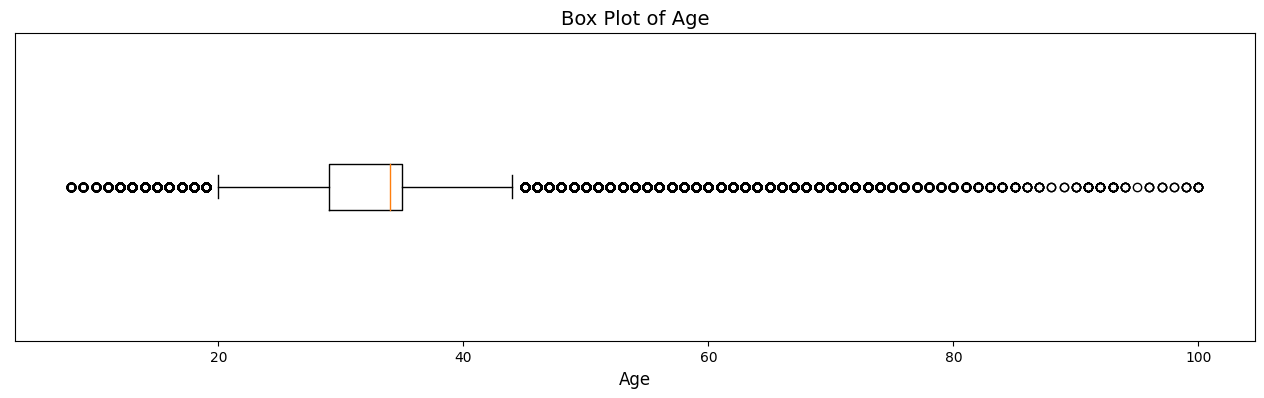

In [50]:
fig = plt.figure(figsize =(16, 4))
 
plt.boxplot(users["age"], vert=False)
plt.title('Box Plot of Age', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.yticks([])
plt.show()

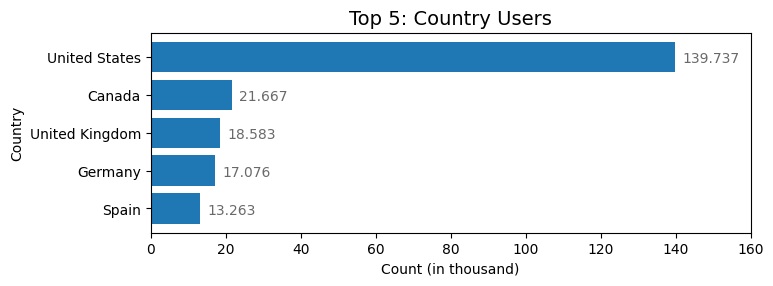

In [51]:
pop_country = users.groupby(['country']).agg({
    'country': [('count')]
})

pop_country.columns = pop_country.columns.droplevel(level=0)
pop5_country = pop_country.sort_values(by='count', ascending=False).head(5)

fig = plt.figure(figsize=(6,2))
ax = fig.add_axes([0,0,1,1])
country = pop5_country.index
cnt = pop5_country['count']/1000
ax.barh(country, cnt)

plt.gca().invert_yaxis()

# Set the tick locations and labels
current_values = plt.gca().get_xticks()
#tick_locations = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000] 
tick_locations = [0, 20, 40, 60, 80, 100, 120, 140, 160] 
ax.set_xticks(tick_locations)
ax.set_xticklabels(['{:,.0f}'.format(x) for x in tick_locations])

for i, v in enumerate(cnt):
    ax.text(v + 2, i + .15, str(v), color='dimgray')

# Set the title and axis labels
plt.title('Top 5: Country Users', fontsize=14)
plt.ylabel('Country', fontsize=10)
plt.xlabel('Count (in thousand)', fontsize=10)

plt.show()

**<font color='DarkBlue'>Books & Ratings:</font>**
____________________

In [52]:
# merge
df = ratings.merge(books[['isbn', 'book_title', 'book_author', 'publisher', 'year_publication']], 
                   how='left', on='isbn')
dfi = ratings_implicit.merge(books[['isbn', 'book_title', 'book_author', 'publisher', 'year_publication']], 
                             how='left', on='isbn')
dfe = ratings_explicit.merge(books[['isbn', 'book_title', 'book_author', 'publisher', 'year_publication']], 
                             how='left', on='isbn')

print(df.shape, dfi.shape, dfe.shape)

(1031136, 7) (647294, 7) (383842, 7)


In [53]:
#  54% of books in the dataset are less than or equal of 2 ratings

cnt_isbn = df.groupby(['isbn']).agg({'isbn': [('count')]})
cnt_isbn.columns = cnt_isbn.columns.droplevel(level=0)
#cnt_isbn.sort_values(by='count', ascending=False).head(10)
cnt_isbn.describe(percentiles=[.5, .54, .75, .95])

,count
count,270151.000000
mean,3.816888
std,13.811690
min,1.000000
50%,1.000000
54%,2.000000
75%,3.000000
95%,12.000000
max,2502.000000


In [54]:
#  56% of users in the dataset are less than or equal of 2 ratings

cnt_user = df.groupby(['user_id']).agg({'user_id': [('count')]})
cnt_user.columns = cnt_user.columns.droplevel(level=0)
#cnt_user.sort_values(by='count', ascending=False).head(5)
cnt_user.describe(percentiles=[.5, .56, .75, .95, 1])

,count
count,92106.000000
mean,11.195101
std,88.685678
min,1.000000
50%,1.000000
56%,2.000000
75%,4.000000
95%,31.000000
100%,11144.000000
max,11144.000000


If I want build hybrid model (CBF & CF) by switching to try to improve the score in collaborative filtering, we drop more of 50% of the database if only take interaction of books, users >= 2.

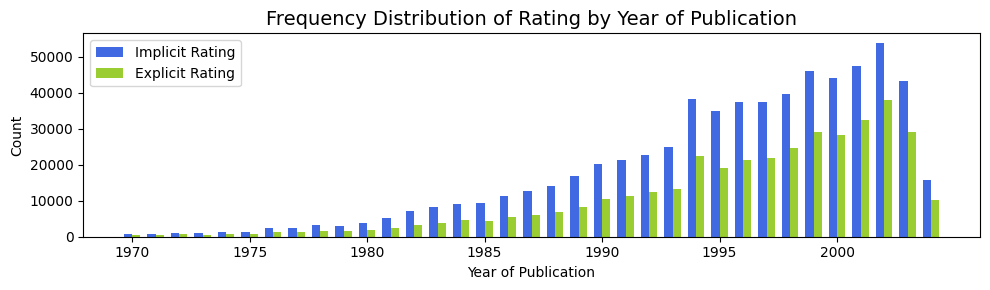

In [55]:
pop_year_i = dfi.groupby(['year_publication']).agg({
    'year_publication': [('count')]})
pop_year_e = dfe.groupby(['year_publication']).agg({
    'year_publication': [('count')]})

pop_year_i.columns = pop_year_i.columns.droplevel(level=0)
pop_year_i = pop_year_i.sort_values(by='year_publication', ascending=False)
pop_year_e.columns = pop_year_e.columns.droplevel(level=0)
pop_year_e = pop_year_e.sort_values(by='year_publication', ascending=False)

pop_year_1 = pop_year_i[pop_year_i.index >= 1970]
pop_year_2 = pop_year_e[pop_year_e.index >= 1970]

fig, ax = plt.subplots(figsize=(10, 3))

# Define the width of the bars
bar_width = 0.35

# Define the x-axis positions for the bars
x = pop_year_1.index

# Create the bars for implicit and explicit ratings
bar1 = ax.bar(x - bar_width/2, pop_year_1['count'], bar_width, label='Implicit Rating', color='royalblue')
bar2 = ax.bar(x + bar_width/2, pop_year_2['count'], bar_width, label='Explicit Rating', color='yellowgreen')

# Set the title and axis labels
plt.title('Frequency Distribution of Rating by Year of Publication', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Year of Publication', fontsize=10)

# Set the x-axis ticks and labels by 5-year intervals
years = range(1970, max(pop_year_1.index) + 1, 5)
ax.set_xticks(years)

# Create x-axis labels for the 5-year intervals
ax.set_xticklabels([str(year) for year in years])

# Create a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [56]:
# 25% of book with implicit rating have year <- 11
# less interaction for old book...
pop_year_i['count'].describe(percentiles=[.25, .5, .75, .95, 1])

count       93.000000
mean      6960.150538
std      13609.089453
min          1.000000
25%         11.000000
50%        163.000000
75%       5125.000000
95%      41099.000000
100%     53814.000000
max      53814.000000
Name: count, dtype: float64

In [57]:
# 25% of book with explicit rating have year <- 8
# less interaction for old book...
pop_year_e['count'].describe(percentiles=[.25, .5, .75, .95, 1])

count       93.000000
mean      4127.333333
std       8570.183690
min          1.000000
25%          8.000000
50%        116.000000
75%       2456.000000
95%      26102.600000
100%     37986.000000
max      37986.000000
Name: count, dtype: float64

In [58]:
ratings_explicit.shape

(383842, 3)

## **<font color='DarkBlue'>Recommandation Systems</font>**

#### <font color='DarkBlue'>Content Based Filtering</font>

Use-Case: Item-to-Item recommendation

We ignore the engagement user in this section. Based on the similarity content of the items.

In [59]:
# Merge the average rating
cbf = books.merge(avg_rating, how='left', on='isbn')
cbf.head(2)

,isbn,book_title,book_author,year_publication,publisher,image_url_m,avg_rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,NaN
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,7.666667


In [60]:
cbf.shape

(271360, 7)

In [61]:
# columns subset
cols_to_keep = ['isbn', 'book_title', 'publisher', 'book_author', 'avg_rating']
cbf = cbf[cols_to_keep]
cbf.sort_values(by='isbn').head()

,isbn,book_title,publisher,book_author,avg_rating
254249,0000913154,The Way Things Work: An Illustrated Encycloped...,Simon &amp; Schuster,C. van Amerongen (translator),8.0
215806,0001010565,Mog's Christmas,Collins,Judith Kerr,NaN
42562,0001046438,Liar,Harpercollins Uk,Stephen Fry,9.0
112555,0001046713,Twopence to Cross the Mersey,HarperCollins Publishers,Helen Forrester,NaN
42604,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",HarperCollins Publishers,T.S. Eliot,6.0


In [62]:
# lower case & removes any leading and trailing whitespaces. 
for i in ['book_title', 'publisher', 'book_author']:
    cbf.loc[:, i] = cbf[i].str.lower()
    cbf.loc[:, i] = cbf[i].str.strip()

cbf['avg_rating'] = cbf['avg_rating'].astype(np.float16)
cbf.head(2)

,isbn,book_title,publisher,book_author,avg_rating
0,0195153448,classical mythology,oxford university press,mark p. o. morford,NaN
1,0002005018,clara callan,harperflamingo canada,richard bruce wright,7.667969


In [63]:
# convert ratings into tiers
def convert_ratings_into_tiers(x):
    
    if pd.isna(x):
        return 'tier 5'
    elif x >= 1 and x <= 4:
        return 'tier 4'
    elif x > 4 and x <= 6:
        return 'tier 3'
    elif x > 6 and x <= 8:
        return 'tier 2'
    else:
        return 'tier 1'

In [64]:
cbf['tier'] = cbf['avg_rating'].apply(lambda x: convert_ratings_into_tiers(x))
cbf.head(10)

,isbn,book_title,publisher,book_author,avg_rating,tier
0,0195153448,classical mythology,oxford university press,mark p. o. morford,NaN,tier 5
1,0002005018,clara callan,harperflamingo canada,richard bruce wright,7.667969,tier 2
2,0060973129,decision in normandy,harperperennial,carlo d'este,7.500000,tier 2
3,0374157065,flu: the story of the great influenza pandemic...,farrar straus giroux,gina bari kolata,7.832031,tier 2
4,0393045218,the mummies of urumchi,w. w. norton &amp; company,e. j. w. barber,NaN,tier 5
5,0399135782,the kitchen god's wife,putnam pub group,amy tan,8.179688,tier 1
6,0425176428,what if?: the world's foremost military histor...,berkley publishing group,robert cowley,8.000000,tier 2
7,0671870432,pleading guilty,audioworks,scott turow,8.000000,tier 2
8,0679425608,under the black flag: the romance and the real...,random house,david cordingly,NaN,tier 5
9,074322678X,where you'll find me: and other stories,scribner,ann beattie,5.000000,tier 3


In [65]:
# merge attributes
def merge_description(df, col_list):
    return df[col_list].apply(lambda x: ' '.join(x), axis=1)

cols_to_merge = ['book_title', 'publisher', 'tier']
cbf= cbf.assign(description=lambda x: merge_description(x, cols_to_merge))
cbf.head(2)

,isbn,book_title,publisher,book_author,avg_rating,tier,description
0,0195153448,classical mythology,oxford university press,mark p. o. morford,NaN,tier 5,classical mythology oxford university press ti...
1,0002005018,clara callan,harperflamingo canada,richard bruce wright,7.667969,tier 2,clara callan harperflamingo canada tier 2


In [66]:
# remove stopwords
cbf['description'] = cbf['description'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stop)]))
cbf.head(2)

,isbn,book_title,publisher,book_author,avg_rating,tier,description
0,0195153448,classical mythology,oxford university press,mark p. o. morford,NaN,tier 5,classical mythology oxford university press ti...
1,0002005018,clara callan,harperflamingo canada,richard bruce wright,7.667969,tier 2,clara callan harperflamingo canada tier 2


We can use TF-IDF or embedding:

1. TF_IDF: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
2. Sentence Transformer: https://www.sbert.net/docs/pretrained_models.html
3. Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder-large/5

TF-IDF:

In [67]:
# Initialize tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',                  # whether the feature should be made of word or character n-grams       
    min_df=1,                         # minimum required occurences of a word 
                                      # (ignore terms that have a document frequency strictly lower than 1)
    encoding='utf-8',                  # encoding
    lowercase=True,                   # convert all words to lowercase
    token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
    norm='l2',                        # L2 normalization
)

In [68]:
# fit to the dataset
features = tfidf_vectorizer.fit_transform(cbf['description'])
features

<271360x81153 sparse matrix of type '<class 'numpy.float64'>'
	with 1951312 stored elements in Compressed Sparse Row format>

In [69]:
book_1 = features[0].toarray()
book_1[book_1 > 0]

array([0.57476454, 0.58429464, 0.39871582, 0.23594546, 0.0663163 ,
       0.33045889])

In [70]:
tfidf_vectorizer.idf_

array([ 8.14056729, 12.81805814, 12.81805814, ..., 12.41259303,
       12.81805814, 12.81805814])

Differente technique to calculate the similarity:

1. Cosine Similarity: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
2. Nearest Neighnors: https://scikit-learn.org/stable/modules/neighbors.html
3. Approximate Nearest Neighbors:
   
    - Annoy: https://github.com/spotify/annoy (CPU More efficient)
    - NMSLIB: https://github.com/nmslib/nmslib --> more popular in industry
    - Faiss: https://github.com/facebookresearch/faiss (CPU More efficient)

Nearest Neighbors:

In [71]:
# Create nearest neighbors
nn = NearestNeighbors(n_neighbors=20).fit(features)

In [72]:
# Create items dictionary
items_dict = dict(enumerate(cbf['isbn']))
items_dict = {v: k for k, v in items_dict.items()}

In [73]:
def recommend(
    book_id, 
    n_rec, 
    features,
    items_dict,
    nearest_neighbors, 
    df
):

    """
    :return: recommendation list
    """

    # Get the index of the movie
    idx = items_dict[book_id]

    # Find the K-neighbors of a point
    distances, indices = nn.kneighbors(features[idx].reshape(1, -1))
    index_list = indices.ravel()

    # Generate top-N recommendations
    out = list()

    i = 0
    while i <= n_rec:
        out.append(
                cbf[cbf.index == index_list[i]][['book_title', 'book_author', 'publisher', 'tier', 'avg_rating']].values[0])
        i += 1

    out = pd.DataFrame(out, columns=['book_title', 'book_author', 'publisher', 'tier', 'avg_rating'])

    return out

In [74]:
out = recommend(
    #book_id="0671870432", 
    book_id="1565921976",
    n_rec=5, 
    items_dict=items_dict,
    features=features, 
    nearest_neighbors=nn,
    df=cbf
)

out

,book_title,book_author,publisher,tier,avg_rating
0,programming python,mark lutz,o'reilly,tier 5,NaN
1,programming python (2nd edition),mark lutz,o'reilly,tier 1,9.500000
2,python programming on win32,mark hammond,o'reilly,tier 2,8.000000
3,python web programming,steve holden,sams,tier 1,9.000000
4,"programming c#, third edition",jesse liberty,o'reilly,tier 5,NaN
5,learning python (help for programmers),mark lutz,o'reilly,tier 1,9.664062


#### <font color='DarkBlue'>Collaborating Filtering</font>

Use-Case: Recommend most relevant items per user.

Differente technique we can use:

- Nearest Neighbors: https://scikit-learn.org/stable/modules/neighbors.html
- Alternating Least Square (ALS) or Bayesian Personalized Ranking(BPR): https://github.com/benfred/implicit/tree/main
- Neural Collaborative Filtering: https://arxiv.org/abs/1708.05031
- LightFM: https://making.lyst.com/lightfm/docs/index.html

##### <font color='DarkBlue'>Implicit Library: Implicit or Explicit Ratings</font>
____________

In [75]:
# see data exploration 
# sub product group which doesn't include thise limited products

def sub_item(tbl, col):
    first_quartile = np.percentile(tbl[col], 25)
    mask = tbl[col] > first_quartile
    out = tbl[mask]
    out.reset_index(inplace=True)
    return out

In [76]:
sub_product_year_i = sub_item(pop_year_i, 'count')
sub_product_year_e = sub_item(pop_year_e, 'count')
sub_product_avg_rating = sub_item(avg_rating, 'avg_rating')

# 93 - 69 = 24 years removed from implicit 
# 93 - 68 = 25 years removed from explicit 
# 149836 - 111752 = 38 084 average rating removed from explicit 
print(pop_year_i.shape, sub_product_year_i.shape)
print(pop_year_e.shape, sub_product_year_e.shape)
print(avg_rating.shape, sub_product_avg_rating.shape)

(93, 1) (69, 2)
(93, 1) (68, 2)
(149836, 1) (111752, 2)


In [77]:
# Merge the average rating
dfe = dfe.merge(avg_rating, how='left', on='isbn')
dfe.head(2)

,user_id,isbn,book_rating,book_title,book_author,publisher,year_publication,avg_rating
0,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,2001,5.0
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,1999,3.0


In [78]:
print(dfi.shape, dfe.shape, df.shape)

(647294, 7) (383842, 8) (1031136, 7)


In [79]:
# create column group_flag for highlight group (0 or 1)

dfi['group_year'] = np.where(dfi['year_publication'].isin(sub_product_year_i['year_publication']), 1, 0)
dfe['group_year'] = np.where(dfe['year_publication'].isin(sub_product_year_e['year_publication']), 1, 0)
dfe['group_avg_rating'] = np.where(dfe['avg_rating'].isin(sub_product_avg_rating['avg_rating']), 1, 0)

In [80]:
dfe.tail()

,user_id,isbn,book_rating,book_title,book_author,publisher,year_publication,avg_rating,group_year,group_avg_rating
383837,276704,0743211383,7,Dreamcatcher,Stephen King,Scribner,2001,6.964912,1,1
383838,276704,0806917695,5,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,Sterling Publishing,1997,5.000000,1,0
383839,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,Longstreet Press,2000,7.000000,1,1
383840,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,Jove Books,1996,8.444444,1,1
383841,276721,0590442449,10,Fourth Grade Rats,Jerry Spinelli,Scholastic,1996,9.000000,1,1


In [81]:
# for the evaluation, remove the group_flag = 0 (not for the training)
dfi_eval_year = dfi[dfi["group_year"] == 1]
dfe_eval_year = dfe[dfe["group_year"] == 1]
dfe_eval_avg_rating = dfe[dfe["group_avg_rating"] == 1]

print(dfi.shape, dfi_eval_year.shape)
print(dfe.shape, dfe_eval_year.shape)
print(dfe.shape, dfe_eval_avg_rating.shape)

(647294, 8) (647201, 8)
(383842, 10) (383761, 10)
(383842, 10) (325206, 10)


In [82]:
# Convert dataset into a csr sparse matrix with users x items format
def cat(tbl, col1, col2):
    tbl[col1] = tbl[col1].astype('category')
    tbl[col2] = tbl[col2].astype('category')

cat(dfi, "user_id", "isbn")
cat(dfi_eval_year, "user_id", "isbn")
cat(dfe, "user_id", "isbn")
cat(dfe_eval_year, "user_id", "isbn")
cat(dfe_eval_avg_rating, "user_id", "isbn")
cat(df, "user_id", "isbn")

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   user_id           1031136 non-null  category
 1   isbn              1031136 non-null  category
 2   book_rating       1031136 non-null  int64   
 3   book_title        1031136 non-null  object  
 4   book_author       1031136 non-null  object  
 5   publisher         1031136 non-null  object  
 6   year_publication  1031136 non-null  int64   
dtypes: category(2), int64(2), object(3)
memory usage: 67.9+ MB


In [84]:
logger.info(f'The unique number of users for dfe: {dfe["user_id"].nunique()}')
logger.info(f'The unique number of books for dfe: {dfe["isbn"].nunique()}')
logger.info(f'The unique number of users for dfe_eval_avg_rating: {dfe_eval_avg_rating["user_id"].nunique()}')
logger.info(f'The unique number of books for dfe_eval_avg_rating: {dfe_eval_avg_rating["isbn"].nunique()}')

The unique number of users for dfe: 68091
The unique number of books for dfe: 149836
The unique number of users for dfe_eval_avg_rating: 61770
The unique number of books for dfe_eval_avg_rating: 111752


In [85]:
# Convert dataset into a csr sparse matrix with users x items format
def matrix_factorization(tbl, name):
    out = csr_matrix(
        (name, (tbl['user_id'].cat.codes.copy(), tbl['isbn'].cat.codes.copy())), 
        dtype=np.float32,
    )
    return out

user_item_data = matrix_factorization(df, df['book_rating'].astype(np.float32))

user_item_data_i = matrix_factorization(dfi, np.ones(len(dfi)))
user_item_data_i_year = matrix_factorization(dfi_eval_year, np.ones(len(dfi_eval_year)))

user_item_data_e = matrix_factorization(dfe, dfe['book_rating'].astype(np.float32))
user_item_data_e_year = matrix_factorization(dfe_eval_year, dfe_eval_year['book_rating'].astype(np.float32))
user_item_data_e_avg = matrix_factorization(dfe_eval_avg_rating, dfe_eval_avg_rating['book_rating'].astype(np.float32))

In [86]:
user_item_data

<92106x270151 sparse matrix of type '<class 'numpy.float32'>'
	with 1031136 stored elements in Compressed Sparse Row format>

In [87]:
df.shape

(1031136, 7)

In [88]:
user_item_data[1].data

array([5., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 5., 5., 0., 6., 6., 7.],
      dtype=float32)

In [89]:
user_item_data_e

<68091x149836 sparse matrix of type '<class 'numpy.float32'>'
	with 383842 stored elements in Compressed Sparse Row format>

In [90]:
dfe.shape

(383842, 10)

In [91]:
user_item_data_e[0].data

array([5., 5., 5., 5., 6., 6., 7.], dtype=float32)

In [92]:
user_item_data_i

<52451x201623 sparse matrix of type '<class 'numpy.float32'>'
	with 647294 stored elements in Compressed Sparse Row format>

In [93]:
dfi.shape

(647294, 8)

In [94]:
user_item_data_i[1].data

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

With implicit library: https://github.com/benfred/implicit/tree/main
- Try on implicit or explixit rating, with BM25, ALS, BPR algo

In [95]:
for i in [0.05, 0.15, 0.25, 0.5, 0.75, 1]:

    # Reduce the weight given to popular books
    item_user_data_bm25 = bm25_weight(user_item_data_e_avg.T, K1=1, B=i) 
    user_item_data_bm25 = item_user_data_bm25.T.tocsr() 
    
    # Initialization
    models = {
        "als": AlternatingLeastSquares,
        "bpr": BayesianPersonalizedRanking,
    }
    
    params = {
        'als': {'factors': 512, 'iterations': 10, 'regularization': 0.5, 'random_state':0},
        'bpr': {'factors': 128, 'iterations': 200, 'learning_rate': 0.4, 'regularization': 0.005, 'random_state':0}
    }
    
    # ALS or BPR ...
    model_name = 'als'
    selected_model = models.get(model_name)(**params.get(model_name))
    
    # Evaluation
    train, test = train_test_split( # https://github.com/benfred/implicit/tree/main
        user_item_data_bm25, 
        train_percentage=0.8, 
        random_state=0 
    )
    assert train.shape[0] == test.shape[0] == user_item_data_bm25.shape[0]
    assert train.data.shape[0] + test.data.shape[0] == user_item_data_bm25.data.shape[0]
    
    selected_model.fit(train, show_progress=False)
    map_at_k = mean_average_precision_at_k( 
        model = selected_model, 
        train_user_items=train, 
        test_user_items=test, # then evaluate with the test set
        K=5,
        show_progress=False, 
        num_threads=1
    )
    logger.info(f'{i}, MAP@5: {map_at_k}')

0.05, MAP@5: 0.015811882895701266
0.15, MAP@5: 0.016213596535353078
0.25, MAP@5: 0.016435047452056876
0.5, MAP@5: 0.016165545638770287
0.75, MAP@5: 0.01576122105807782
1, MAP@5: 0.015320558885104184


**Explicit** - Hyper parameters by iteration:

**ALS:**
- Factors: 64, 128, 256, **512**, 1024 --> MAP@5 (%): 0.9, 1.1, 1.3, **1.4**, 1.3
- Iterations: **10**, 20, 50, 100 --> MAP@5 (%): **1.42**, 1.40, 1.38, 1.38
- Regularization: **0.5**, 0.1, 0.05, 0.01 --> MAP@5 (%): **1.43**, 1.42, 1.42, 1.42          
- With normalization --> MAP@5 (%): 0.93
- With BM25 - k1: **1**, 10, 50, 100  --> MAP@5 (%): **1.41**, 0.67, 0.47, 0.43
- With BM25 - B: 0.05, 0.15, **0.25**, 0.5, 0.75, 1 --> MAP@5 (%): 1.48, 1.49, **1.49**, 1.47, 1.41, 1.30
- With subclass for year --> MAP@5 (%): 1.36
- With subclass for average ratings --> MAP@5 (%): **<font color='blue'>1.64</font>**

**BPR:**
- Factors: 64, **128**, 256, 512, 1024 --> MAP@5 (%): 0.56, **0.63**, 0.62, 0.60, 0.61
- Iterations: 50, 100, 150, **200**, 250 --> MAP@5 (%): 0.48, 0.63, 0.67, **0.73**, 0.73
- Learning Rate: 0.5, **0.4**, 0.3, 0.2, 0.1, 0.01 --> MAP@5 (%): 0.84, **0.87**, 0.85, 0.77, 0.73, 0.49
- Regularization: 0.1, 0.05, 0.01, **0.005** --> MAP@5 (%): 0.26, 0.54, 0.81, **0.86**
- With normalization --> MAP@5 (%): 0.83
- With BM25 - k1: 1, 10, 50, 100, 200 --> MAP@5 (%): 0.82, 0.82, 0.79, 0.81, 0.85
- With BM25 - B: 0.05, 0.15, 0.25, 0.5, 0.75, 1 --> MAP@5 (%): 0.81, 0.84, 0.81, 0.84, 0.82, 0.81
- Without subclass for year --> MAP@5 (%): 0.78
- With subclass for average ratings --> MAP@5 (%): **0.99**

**Implicit** - Hyper parameters by iteration:

**ALS:**
- Factors: 64, 128, 256, 512, **1024** --> MAP@5 (%): 0.55, 0.57, 0.58, 0.75, **0.82**
- Iterations: **10**, 20, 50, 100 --> MAP@5 (%): **0,82**, 0.82, 0.81, 0.81
- Regularization: **0.5**, 0.1, 0.05, 0.01 --> MAP@5 (%): **0.82**, 0.80, 0.80, 0.78       
- With BM25 - k1: **1**, 10, 50, 100  --> MAP@5 (%): **0.62**, 0.43, 0.40, 0.40
- With BM25 - B: **0.05**, 0.10, 0.15, 0.25 --> MAP@5 (%): **1.07**, 1.06, 1.04, 0.96
- With subclass for year --> MAP@5 (%): **1.12**

**BPR:**
- Factors: 64, 128, 256, 512, **1024** --> MAP@5 (%): 0.39, 0.47, 0.47, 0.47, 0.48, **0.53**
- Iterations: 50, 100, 150, **200**, 250 --> MAP@5 (%): 0.39, 0.53, 0.57, **0.62**, 0.62
- Learning Rate: **0.3**, 0.2, 0.1, 0.05 --> MAP@5 (%): **0.84**, 0.80, 0.71, 0.62
- Regularization: 0.05, 0.01, **0.005** --> MAP@5 (%): 0.51, 0.78, **0.91**
- With BM25 - k1: **1**, 10, 50, 100, 200 --> MAP@5 (%): **0.79**, 0.78, 0.79, 0.78, 0.75
- With BM25 - B: 0.05, **0.15**, 0.25, 0.75, 1 --> MAP@5 (%): 0.82, **1.30**, 0.81, 1.06, 0.89
- With subclass for year --> MAP@5 (%): 0.77

In [96]:
#Final model with all score after my choice of hyper parameters 

# Reduce the weight given to popular books
item_user_data_bm25 = bm25_weight(user_item_data_e_avg.T, K1=1, B=0.25) 
user_item_data_bm25 = item_user_data_bm25.T.tocsr()

# Initialization
models = {"als": AlternatingLeastSquares}  
params = {'als': {'factors': 512, 'iterations': 10, 'regularization': 0.5, 'random_state':0}}
    
# ALS 
model_name = 'als'
als_model = models.get(model_name)(**params.get(model_name))
    
# Evaluation
train, test = train_test_split( # function from evaluation in github
    user_item_data_bm25, 
    train_percentage=0.8, 
    random_state=0 # reproduce result
)
assert train.shape[0] == test.shape[0] == user_item_data_bm25.shape[0]
assert train.data.shape[0] + test.data.shape[0] == user_item_data_bm25.data.shape[0]
    
start = time.time()
als_model.fit(train, show_progress=False)
end = time.time()
logger.info(f'The training time: {(end - start) } seconds')

The training time: 27.29949188232422 seconds


In [97]:
start = time.time()
map_at_k = mean_average_precision_at_k( 
    model=als_model, 
    train_user_items=train, 
    test_user_items=test, 
    K=5,
    show_progress=False, 
    num_threads=1
)
end = time.time()
logger.info(f'The evaluation time: {(end - start) } seconds')
logger.info(f'MAP@5: {map_at_k}')

The evaluation time: 11.600022077560425 seconds
MAP@5: 0.016435047452056876


In [98]:
from implicit.evaluation import precision_at_k
#precision_at_k
start = time.time()
precision_result = precision_at_k( 
    model=als_model, 
    train_user_items=train, 
    test_user_items=test, 
    K=5,
    show_progress=False, 
    num_threads=1
)
end = time.time()
logger.info(f'The evaluation time: {(end - start) } seconds')
logger.info(f'Precision@5: {precision_result}')

The evaluation time: 11.810950994491577 seconds
Precision@5: 0.03375716543605954


In [99]:
# With NDCG to compare 
start = time.time()
ndcg_result = ndcg_at_k(
    model=als_model, 
    train_user_items=train, 
    test_user_items=test, 
    K=5, 
    show_progress=False, 
    num_threads=1
)
end = time.time()
logger.info(f'The evaluation time: {(end - start) } seconds')
logger.info(f'NDCG@5: {ndcg_result}')

The evaluation time: 12.415424108505249 seconds
NDCG@5: 0.022444081701496744


In [100]:
# With auc_at_k to compare 
start = time.time()
AUC_result = AUC_at_k(
    model=als_model, 
    train_user_items=train, 
    test_user_items=test, 
    K=5, 
    show_progress=False, 
    num_threads=1
)
end = time.time()
logger.info(f'The evaluation time: {(end - start) } seconds')
logger.info(f'AUC@5: {AUC_result}')

The evaluation time: 11.618900299072266 seconds
AUC@5: 0.510826505244257


In [101]:
# Create mapping dictionaries
user_dict = dict((v, k) for k, v in dict(enumerate(dfe['user_id'].cat.categories)).items())
item_dict = dict(enumerate(dfe['isbn'].cat.categories))

In [102]:
# convert into pandas dataframe
items_df = pd.DataFrame(item_dict, index=['isbn']).T    
items_df.reset_index(inplace=True)
items_df.rename(columns={'index': 'id'}, inplace=True)
items_df.head()

,id,isbn
0,0,0000913154
1,1,0001046438
2,2,000104687X
3,3,0001047213
4,4,0001047973


In [103]:
# same for the users
users_df = pd.DataFrame(dict(enumerate(dfe['user_id'].cat.categories)), index=['user_id']).T    
users_df.reset_index(inplace=True)
users_df.rename(columns={'index': 'id'}, inplace=True)
users_df.head()

,id,user_id
0,0,8
1,1,9
2,2,12
3,3,14
4,4,16


In [104]:
# Training
# tha ALS model on the entire dataset and the entire user item data (not just on the train subset)
# we want to have the maximum amount of data, leverage all the data to capture all the existing patern in the data set

model_name = 'als'
als_model = models.get(model_name)(**params.get(model_name))
als_model.fit(user_item_data_e, show_progress=True)

# Model serialization (Course 3/module 3/dev-data/model/classic_model.pkl)
training_als = {
    "users_df": users_df,
    "items_df": items_df,
    'model': als_model
}

# we can save on AWS / GCP / Azure Bucket also
with open(f'model/training_als.pkl', 'wb') as f:
    pickle.dump(training_als, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

  0%|          | 0/10 [00:00<?, ?it/s]

In [105]:
# Model artifact

logger.info(f'Users embedding shape : {als_model.user_factors.shape}')
logger.info(f'Movies embedding shape : {als_model.item_factors.shape}')

Users embedding shape : (68091, 512)
Movies embedding shape : (149836, 512)


Inference:

In [106]:
# Initialize model
with open(os.path.join(f'model/', 'training_als.pkl'), 'rb') as f:
    training_als = pickle.load(f)
f.close()

#training_output
als_model = training_als['model']
users_df = training_als['users_df']
items_df = training_als['items_df']

Personalization:

In [107]:
# Create a list of extra articles to filter out from personalized lists
item_to_filter = dfe[dfe['group_avg_rating'] == 0]['isbn'].unique()
#logger.info(f'The number of items to filter: {len(item_to_filter)}')
rev_item_dict = dict((v, k) for k, v in item_dict.items())
item_to_filter = [rev_item_dict[item] for item in item_to_filter]

In [108]:
len(item_to_filter)

38084

In [109]:
## use-case: Single user prediction (static history) with filtered itmes
user_id = 36003
#user_id = 18067

logger.info(f'The number of explicit rating: {len(dfe[dfe["user_id"] == user_id])}')
logger.info(f'The number of explicit average rating <= 6.5: {len(dfe[(dfe["user_id"] == user_id) & (dfe["avg_rating"] <= 6.5)])}')

customer_id = user_dict[user_id]
logger.info(f'user_id: {user_id}')

start = time.time()
ids, scores = als_model.recommend( 
        userid=customer_id, 
        user_items=user_item_data_e[customer_id], 
        N=5, 
        filter_already_liked_items=True,
        filter_items=item_to_filter, #None, 
        recalculate_user=False, #
) #other parameter --> items: rank only items in this list (not all item in our dataset)

end = time.time()
logger.info(f'The elapsed time: {(end - start) * 1000} milliseconds')

logger.info(f'ids: {ids}')
logger.info(f'scores: {scores}')

ids_mf = pd.DataFrame(ids.T, columns=[user_id])
ids_mf = pd.melt(ids_mf, var_name='user_id', value_name='id')

scores_mf = pd.DataFrame(scores.T, columns=[user_id])
scores_mf = pd.melt(scores_mf, var_name='user_id', value_name='score')

usecase_1 = pd.concat([ids_mf, scores_mf[['score']]], axis=1)
usecase_1 = usecase_1.set_index(['id'])
usecase_1['isbn'] = items_df['isbn'] #map id to the actual article id
usecase_1 = pd.merge(
    usecase_1, 
    books[['isbn', 'book_title', 'book_author', 'year_publication', 'publisher']], 
    how='left', 
    on='isbn'
)

The number of explicit rating: 39
The number of explicit average rating <= 6.5: 0
user_id: 36003
The elapsed time: 16.588211059570312 milliseconds
ids: [ 37440  74526 121105 121065 125824]
scores: [0.36883312 0.3664825  0.35274267 0.33950928 0.3127002 ]


In [110]:
#customer history 
dfe[dfe['user_id'] == user_id][['user_id', 'isbn', 'book_title', 'book_author', 'year_publication', 'publisher', 'avg_rating','group_avg_rating']]

,user_id,isbn,book_title,book_author,year_publication,publisher,avg_rating,group_avg_rating
57389,36003,0060196122,Veronika Decides to Die,Paulo Coelho,2000,HarperCollins Publishers,7.900000,1
57390,36003,0060502304,The Great Train Robbery,Michael Crichton,2002,Avon Books,7.333333,1
57391,36003,0140018328,Kiss Kiss (French Language Edition),Roald Dahl,1978,French &amp; European Pubns,8.000000,1
57392,36003,0140282734,A Portrait of the Artist as a Young Man (Essen...,James Joyce,2000,Penguin Books Ltd,9.500000,1
57393,36003,0140293248,The Girls' Guide to Hunting and Fishing,Melissa Bank,2000,Penguin Books,6.909091,1
57394,36003,0140298479,Bridget Jones: The Edge of Reason,Helen Fielding,2001,Penguin Books,7.539823,1
57395,36003,0140373624,The Complete Adventures of Charlie and Mr.Will...,Roald Dahl,1995,Puffin Books,9.500000,1
57396,36003,0140436936,Nothing...Except My Genius (Penguin Classics),Oscar Wilde,1997,Penguin Books Ltd,7.500000,1
57397,36003,0140482091,The Importance of Being Earnest and Other Plays,Oscar Wilde,1986,Penguin Books,9.333333,1
57398,36003,0140620664,Mansfield Park (Penguin Popular Classics),Jane Austen,1994,Penguin Books Ltd,8.545455,1


In [111]:
# recommendation (not show isbn)
usecase_1[['user_id', 'score', 'book_title','book_author','publisher','year_publication']]

,user_id,score,book_title,book_author,publisher,year_publication
0,36003,0.368833,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,Anchor,1990
1,36003,0.366482,SHIPPING NEWS,Annie Proulx,Scribner,1994
2,36003,0.352743,Chicken Soup for the Teenage Soul II (Chicken ...,Jack Canfield,HCI Teens,1998
3,36003,0.339509,A 3rd Serving of Chicken Soup for the Soul (Ch...,Jack Canfield,Health Communications,1996
4,36003,0.312700,How to Be Good,Nick Hornby,Riverhead Books,2002


Other use-case (Module 4):
- use-case 1: Single user prediction (static history)
- use-case 3: Single user prediction (static history) with liked items included
- use-case 4: Single user prediction (new history)
- use-case 5: Batch prediction (static history)
- Non-presonalized item to item recommendation
- Non-presonalized user to user recommendation

##### <font color='DarkBlue'>LightFM Library: Implicit & Explicit Ratings</font>
_________

In [112]:
dataset = Dataset()

dataset.fit(users=df['user_id'], 
            items=df['isbn'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_books: {num_topics}.')

Num users: 92106, num_books: 270151.


In [113]:
logger.info(f'The unique number of users for df: {df["user_id"].nunique()}')
logger.info(f'The unique number of books for df: {df["isbn"].nunique()}')

The unique number of users for df: 92106
The unique number of books for df: 270151


In [114]:
# interection matrix: It is a matrix that contains user/ item interections 
# weights: weight of interection matrix. Less weight means less importance to that interection matrix.
(interactions, weights) = dataset.build_interactions(df.iloc[:, 0:3].values)

In [115]:
interactions

<92106x270151 sparse matrix of type '<class 'numpy.int32'>'
	with 1031136 stored elements in COOrdinate format>

In [116]:
weights

<92106x270151 sparse matrix of type '<class 'numpy.float32'>'
	with 1031136 stored elements in COOrdinate format>

In [117]:
train, test = random_train_test_split( #https://github.com/lyst/lightfm/blob/master/lightfm/cross_validation.py
        interactions, 
        test_percentage=0.2, 
        random_state=0 
    )
assert train.shape[0] == test.shape[0] == interactions.shape[0]
assert train.data.shape[0] + test.data.shape[0] == interactions.data.shape[0]

In [118]:
train_w, test_w = random_train_test_split( 
        weights, 
        test_percentage=0.2, 
        random_state=0 
    )
assert train.shape[0] == test.shape[0] == weights.shape[0]
assert train.data.shape[0] + test.data.shape[0] == weights.data.shape[0]

In [119]:
from lightfm.evaluation import precision_at_k

for i in [1]:
    model = LightFM(loss='warp', # logistic, BPR, WARP, k-OS WARP
                    no_components=50, #the dimensionality of the feature latent embeddings.
                    learning_rate=0.01,                 
                    random_state=0)

    #sample_weight: matrix with entries expressing weights of individual interactions from the interactions matrix.
    model.fit(interactions=train, 
              sample_weight = train_w, 
              epochs=10, 
              num_threads=4);

    print(i)
    print("Train precision: %.4f" % precision_at_k(model, train, k=5).mean())
    print("Test precision: %.4f" % precision_at_k(model, test, k=5, train_interactions=train).mean())
    print("Train auc: %.4f" % auc_score(model, train, num_threads=4).mean())
    print("Test auc: %.4f" %  auc_score(model, test, train_interactions=train, num_threads=4).mean())

1
Train precision: 0.0135
Test precision: 0.0065
Train auc: 0.8448
Test auc: 0.7522


Hyper parameters by iteration:

- no_components: 20, **50**, 100, train / test precision: (1.60/0.65) **(3.65/0.69)** (8.56/0.70), train / test auc: (96.73/77.32) **(99.48/77.37)** (99.86/77.23)
- learning_rate: **0.01**, 0.05, train / test precision: **(1.18/0.69)** (3.65/0.69), train / test auc: **(86.84/76.04)** (99.48/77.37) --> less overfitting
- epochs: **10**, 20,  train / test precision: **(1.18/0.69)** (1.18/0.70), train / test auc: **(86.84/76.04)** (89.49/77.04)
- with sample_weight: train / test precision: 1.35 / 0.65, train / test auc: 84.48 / 75.22

In [120]:
df.head(2)

,user_id,isbn,book_rating,book_title,book_author,publisher,year_publication
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books,2002
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,2001


In [121]:
interactions.row

array([    0,     1,     2, ..., 92103, 92104, 92105], dtype=int32)

The order of elements in interactions matrices is based on the order of the rows and columns in your original dataset. The first dimension corresponds to the users, and the second dimension corresponds to the items. The order is determined by how the data was organized in df.iloc[:, 0:3].values.

In [122]:
# Create mapping dictionaries
user_dict = dict((v, k) for k, v in dict(enumerate(df['user_id'].cat.categories)).items())
item_dict = dict(enumerate(df['isbn'].cat.categories))

In [123]:
# convert into pandas dataframe
items_df = pd.DataFrame(item_dict, index=['isbn']).T    
items_df.reset_index(inplace=True)
items_df.rename(columns={'index': 'id'}, inplace=True)
items_df.head()

,id,isbn
0,0,0000913154
1,1,0001010565
2,2,0001046438
3,3,0001046713
4,4,000104687X


In [124]:
# same for the users
users_df = pd.DataFrame(dict(enumerate(dfe['user_id'].cat.categories)), index=['user_id']).T    
users_df.reset_index(inplace=True)
users_df.rename(columns={'index': 'id'}, inplace=True)
users_df.head()

,id,user_id
0,0,8
1,1,9
2,2,12
3,3,14
4,4,16


In [125]:
# Training
# tha ALS model on the entire dataset and the entire user item data (not just on the train subset)
# we want to have the maximum amount of data, leverage all the data to capture all the existing patern in the data set

model_lightfm = LightFM(loss='warp', # logistic, BPR, WARP, k-OS WARP
                        no_components=50, #the dimensionality of the feature latent embeddings.
                        learning_rate=0.01,                 
                        random_state=0)

model_lightfm.fit(interactions=interactions, epochs=10, num_threads=4);

# Model serialization (Course 3/module 3/dev-data/model/classic_model.pkl)
model_lightfm_cb = {
    "users_df": users_df,
    "items_df": items_df,
    'model': model_lightfm
}

# we can save on AWS / GCP / Azure Bucket also
with open(f'model/model_lightfm_cb.pkl', 'wb') as f:
    pickle.dump(model_lightfm_cb, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [126]:
# Inference

# Initialize model
with open(os.path.join(f'model/', 'model_lightfm_cb.pkl'), 'rb') as f:
    model_lightfm_cb = pickle.load(f)
f.close()

#training_output
model_lightfm = model_lightfm_cb['model']
users_df = model_lightfm_cb['users_df']
items_df = model_lightfm_cb['items_df']

In [127]:
user_id = 36003

num_items_to_recommend=5
customer_id = user_dict[user_id]
logger.info(f'user_id: {user_id}')

n_users, n_items = interactions.shape
logger.info(f'n_users: {n_users}, n_items: {n_items}')
all_item_ids = list(range(0, n_items)) # List of item IDs for which you want to generate recommendations

recommendations = model_lightfm.predict(user_ids=customer_id, item_ids=all_item_ids) # customer_id or user_id ??? ok customer_id
ranking_score = np.sort(recommendations)[::-1][:num_items_to_recommend] # They are simply a means of ranking the items.

# Sort the recommendations in descending order by score
recommended_item_ids = np.argsort(recommendations)[::-1][:num_items_to_recommend]

logger.info(f'ids: {recommended_item_ids}')
logger.info(f'scores: {ranking_score}')

ids_mf = pd.DataFrame(recommended_item_ids.T, columns=[user_id])
ids_mf = pd.melt(ids_mf, var_name='user_id', value_name='id')

scores_mf = pd.DataFrame(ranking_score.T, columns=[user_id])
scores_mf = pd.melt(scores_mf, var_name='user_id', value_name='ranking_score')

usecase_2 = pd.concat([ids_mf, scores_mf[['ranking_score']]], axis=1)
usecase_2 = usecase_2.set_index(['id'])
usecase_2['isbn'] = items_df['isbn'] #map id to the actual article id
usecase_2 = pd.merge(
    usecase_2, 
    books[['isbn', 'book_title', 'book_author', 'year_publication', 'publisher']], 
    how='left', 
    on='isbn'
)

user_id: 36003
n_users: 92106, n_items: 270151
ids: [ 335  306  309 1075  551]
scores: [1.0914283  0.6441974  0.5133871  0.4679039  0.44867015]


In [128]:
usecase_2[['user_id', 'ranking_score', 'book_title', 'book_author', 'publisher', 'year_publication']]

,user_id,ranking_score,book_title,book_author,publisher,year_publication
0,36003,1.091428,A Day in the Life of Hollywood (Day in the Life),Bill Messing,Collins Publishers,1992
1,36003,0.644197,Swimmer,Bill Broady,Flamingo,2000
2,36003,0.513387,"Lust, Or, No Harm Done",Geoff Ryman,Flamingo,2001
3,36003,0.467904,Druidry,Emma Restall Orr,Thorsons Publishers,2001
4,36003,0.448670,The Honey Ant,Duncan Kyle,HarperCollins Publishers,1989


#### <font color='DarkBlue'>Hybrid</font>

##### <font color='DarkBlue'>LightFM Library - Hybrid Content-Collaborative Filtering: Weighting</font>
_________

Example of code here:
- https://gitee.com/fruitwater/recommenders/blob/master/examples/02_model_hybrid/lightfm_deep_dive.ipynb
- https://github.com/lyst/lightfm/blob/master/examples/stackexchange/hybrid_crossvalidated.ipynb

In [129]:
# Merge the users dataset
df = df.merge(users, how='left', on='user_id')
cat(df, "user_id", "isbn")
df.head(2)

,user_id,isbn,book_rating,book_title,book_author,publisher,year_publication,age,country
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books,2002,34,United States
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,2001,34,United States


In [130]:
# convert ratings into tiers
def convert_age(x):
    
    if x >= 0 and x <= 14:
        return 'children'
    elif x > 14 and x <=24:
        return 'teeneger'
    elif x > 24 and x <= 64:
        return 'adult'
    else:
        return 'senior'

df['age_class'] = df['age'].apply(lambda x: convert_age(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   user_id           1031136 non-null  category
 1   isbn              1031136 non-null  category
 2   book_rating       1031136 non-null  int64   
 3   book_title        1031136 non-null  object  
 4   book_author       1031136 non-null  object  
 5   publisher         1031136 non-null  object  
 6   year_publication  1031136 non-null  int64   
 7   age               1031136 non-null  int32   
 8   country           1031136 non-null  object  
 9   age_class         1031136 non-null  object  
dtypes: category(2), int32(1), int64(2), object(5)
memory usage: 87.6+ MB


In [131]:
df.head()

,user_id,isbn,book_rating,book_title,book_author,publisher,year_publication,age,country,age_class
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books,2002,34,United States,adult
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,2001,34,United States,adult
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books,1996,16,Australia,teeneger
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,1999,16,Croatia,teeneger
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press,2001,16,Croatia,teeneger


In [132]:
logger.info(f'The unique number of users: {df["user_id"].nunique()}')
logger.info(f'The unique number of books: {df["isbn"].nunique()}')
logger.info(f'The unique number of publisher: {df["publisher"].nunique()}')
logger.info(f'The unique number of author: {df["book_author"].nunique()}')
logger.info(f'The unique number of title: {df["book_title"].nunique()}')
logger.info(f'The unique number of country: {df["country"].nunique()}')
logger.info(f'The unique number of age: {df["age"].nunique()}')
logger.info(f'The unique number of age_class: {df["age_class"].nunique()}')

The unique number of users: 92106
The unique number of books: 270151
The unique number of publisher: 16726
The unique number of author: 101586
The unique number of title: 241071
The unique number of country: 164
The unique number of age: 90
The unique number of age_class: 4


In [133]:
all_publishers = df['publisher'].unique()
all_age_class = df['age_class'].unique()
all_country = df['country'].unique()

# fit method creates the user/item id mappings.
dataset = Dataset()
dataset.fit(users=df['user_id'], 
            items=df['isbn'])
#dataset.fit_partial(item_features=all_publishers)
#dataset.fit_partial(user_features=all_country)
dataset.fit_partial(user_features=all_age_class)

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Number of users: {num_users}, Number of books: {num_topics}')

Number of users: 92106, Number of books: 270151


In [134]:
#item_feature = dataset.build_item_features(
#    (x, [y]) for x,y in zip(df.isbn, df['publisher']))
#item_features

In [135]:
user_feature = dataset.build_user_features(
    (x, [y]) for x,y in zip(df.user_id, df['age_class']))

#user_feature = dataset.build_user_features(
#    (x, [y]) for x,y in zip(df.user_id, df['country']))

user_feature

<92106x92110 sparse matrix of type '<class 'numpy.float32'>'
	with 184212 stored elements in Compressed Sparse Row format>

In [136]:
(interactions, weights) = dataset.build_interactions(df.iloc[:, 0:3].values)

In [137]:
interactions

<92106x270151 sparse matrix of type '<class 'numpy.int32'>'
	with 1031136 stored elements in COOrdinate format>

In [138]:
train, test = cross_validation.random_train_test_split( #https://github.com/lyst/lightfm/blob/master/lightfm/cross_validation.py
        interactions, 
        test_percentage=0.2, 
        random_state=0 
    )

train_w, test_w = cross_validation.random_train_test_split( #https://github.com/lyst/lightfm/blob/master/lightfm/cross_validation.py
        weights, 
        test_percentage=0.2, 
        random_state=0 
    )

assert train.shape[0] == test.shape[0] == interactions.shape[0]
assert train.data.shape[0] + test.data.shape[0] == interactions.data.shape[0]

assert train_w.shape[0] == test_w.shape[0] == weights.shape[0]
assert train_w.data.shape[0] + test_w.data.shape[0] == weights.data.shape[0]

In [139]:
model2 = LightFM(loss='warp', 
                 no_components=50, 
                 learning_rate=0.01, 
                 #item_alpha=ITEM_ALPHA, #L2 penalty on item features.
                 #user_alpha=USER_ALPHA, #L2 penalty on user features.
                 random_state=0)

model2.fit(interactions=train,
           #item_features=item_feature,
           user_features=user_feature,
           sample_weight = train_w, 
           epochs=10,
           num_threads=4);

In [140]:
#add cross validation and rebuild item/user
print("Train precision: %.4f" % precision_at_k(
    model2, train, user_features = user_feature, 
    #item_features=item_feature, 
    k=5, num_threads=4).mean()
     )
print("Test precision: %.4f" % precision_at_k(
    model2, test, k=5, user_features = user_feature, 
    #item_features=item_feature, 
    train_interactions=train, num_threads=4).mean()
     )
print("Train auc: %.4f" % auc_score(
    model2, train, user_features = user_feature, 
    #item_features=item_feature, 
    num_threads=4).mean()
     )
print("Test auc: %.4f" %  auc_score(
    model2, test, user_features = user_feature, 
    #item_features=item_feature, 
    train_interactions=train, num_threads=4).mean()
     )

Train precision: 0.0117
Test precision: 0.0070
Train auc: 0.8299
Test auc: 0.7556


**Hyper parameters by iteration:**

- item (publisher) / user (country): train / test precision: 0.90 / 0.51, train / test auc: 88.08 / 83.23
- user (country): train / test precision: 1.13 / 0.67, train / test auc: 88.84 / 79.07
- **user (age_class):** train / test precision: 1.19 / 0.73, train / test auc: 83.34 / 75.10
- user (age_class) & weights: train / test precision: 1.17 / 0.70, train / test auc: 82.99 / 75.56

The choice between high precision and high AUC depends on the specific goals of your recommendation system:

High Precision: If your primary goal is to provide highly accurate and relevant recommendations to users, you would aim for high precision. This is particularly important in applications where users are shown a limited number of recommendations, and the focus is on ensuring that those recommendations are as relevant as possible.

High AUC: If your system's primary goal is to ensure that relevant items are ranked higher than irrelevant ones, even if it means including some less relevant items in the recommendation list, you might prioritize AUC. This is often the case in systems where users have the option to explore many recommendations or where the system needs to be good at separating relevant from irrelevant items across the entire item catalog.

In [141]:
# Create mapping dictionaries
user_dict = dict((v, k) for k, v in dict(enumerate(df['user_id'].cat.categories)).items())
item_dict = dict(enumerate(df['isbn'].cat.categories))

In [142]:
# convert into pandas dataframe
items_df = pd.DataFrame(item_dict, index=['isbn']).T    
items_df.reset_index(inplace=True)
items_df.rename(columns={'index': 'id'}, inplace=True)
items_df.head()

,id,isbn
0,0,0000913154
1,1,0001010565
2,2,0001046438
3,3,0001046713
4,4,000104687X


In [143]:
# same for the users
users_df = pd.DataFrame(dict(enumerate(dfe['user_id'].cat.categories)), index=['user_id']).T    
users_df.reset_index(inplace=True)
users_df.rename(columns={'index': 'id'}, inplace=True)
users_df.head()

,id,user_id
0,0,8
1,1,9
2,2,12
3,3,14
4,4,16


In [144]:
# Training
# tha ALS model on the entire dataset and the entire user item data (not just on the train subset)
# we want to have the maximum amount of data, leverage all the data to capture all the existing patern in the data set

model2 = LightFM(loss='warp', 
                 no_components=50, 
                 learning_rate=0.01, 
                 #item_alpha=ITEM_ALPHA, #L2 penalty on item features.
                 #user_alpha=USER_ALPHA, #L2 penalty on user features.
                 random_state=0)

model2.fit(interactions=interactions,
           #item_features=item_feature,
           user_features=user_feature,
           epochs=10,
           num_threads=4);

# Model serialization (Course 3/module 3/dev-data/model/classic_model.pkl)
model_lightfm_h = {
    "users_df": users_df,
    "items_df": items_df,
    'model': model2
}

# we can save on AWS / GCP / Azure Bucket also
with open(f'model/model_lightfm_h.pkl', 'wb') as f:
    pickle.dump(model_lightfm_h, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [145]:
# Inference

# Initialize model
with open(os.path.join(f'model/', 'model_lightfm_h.pkl'), 'rb') as f:
    model_lightfm_h = pickle.load(f)
f.close()

#training_output
model_lightfm2 = model_lightfm_h['model']
users_df = model_lightfm_h['users_df']
items_df = model_lightfm_h['items_df']

In [146]:
user_id = 36003
num_items_to_recommend=5

customer_id = user_dict[user_id]
logger.info(f'user_id: {user_id}')

n_users, n_items = interactions.shape
logger.info(f'n_users: {n_users}, n_items: {n_items}')
all_item_ids = list(range(0, n_items)) 

recommendations = model_lightfm2.predict(user_ids=customer_id, item_ids=all_item_ids) 
ranking_score = np.sort(recommendations)[::-1][:num_items_to_recommend] 

# Sort the recommendations in descending order by score
recommended_item_ids = np.argsort(recommendations)[::-1][:num_items_to_recommend]

logger.info(f'ids: {recommended_item_ids}')
logger.info(f'scores: {ranking_score}')

ids_mf = pd.DataFrame(recommended_item_ids.T, columns=[user_id])
ids_mf = pd.melt(ids_mf, var_name='user_id', value_name='id')

scores_mf = pd.DataFrame(ranking_score.T, columns=[user_id])
scores_mf = pd.melt(scores_mf, var_name='user_id', value_name='ranking_score')

usecase_3 = pd.concat([ids_mf, scores_mf[['ranking_score']]], axis=1)
usecase_3 = usecase_3.set_index(['id'])
usecase_3['isbn'] = items_df['isbn'] #map id to the actual article id
usecase_3 = pd.merge(
    usecase_3, 
    books[['isbn', 'book_title', 'book_author', 'year_publication', 'publisher']], 
    how='left', 
    on='isbn'
)

user_id: 36003
n_users: 92106, n_items: 270151
ids: [  858  3016 10114 41153 18787]
scores: [0.09467445 0.09273248 0.09117133 0.08891956 0.08890858]


In [147]:
usecase_3[['user_id', 'ranking_score', 'book_title', 'book_author', 'publisher', 'year_publication']]

,user_id,ranking_score,book_title,book_author,publisher,year_publication
0,36003,0.094674,My Friend Matt and Hena the Whore,Adam Zameenzad,Fontana Paperbacks,1994
1,36003,0.092732,Mmmmmmm: a feastiary,Ruth Reichl,"Holt, Rinehart and Winston",1972
2,36003,0.091171,After All These Years,Susan Isaacs,HarperTorch,1994
3,36003,0.088920,Rubber Gloves or Jimmy Choos,Faith Bleasdale,Hodder &amp; Stoughton Ltd,2000
4,36003,0.088909,"Up with Skool! (Puffin Jokes, Games &amp; Puzz...",Quentin Blake,Puffin Books,1981


The order of elements in interactions matrices is based on the order of the rows and columns in your original dataset. The first dimension corresponds to the users, and the second dimension corresponds to the items. The order is determined by how the data was organized in df.iloc[:, 0:3].values.

In [149]:
items_df[items_df['id']==858]

,id,isbn
858,858,0006543456


In [150]:
books[books['isbn']=='0006543456']

,isbn,book_title,book_author,year_publication,publisher,image_url_m
176058,0006543456,My Friend Matt and Hena the Whore,Adam Zameenzad,1994,Fontana Paperbacks,http://images.amazon.com/images/P/0006543456.0...
